<div align ="center"> <h2> Monte Carlo Integration Using Neural Network Surrogate </h2>
</div>

This project aims to estimate the integral of a complex 2D function using Monte Carlo integration, and accelerate it by training a neural network surrogate model to approximate the function.

Overview:
* Define a complex function f(x,y) over a 2D domain
* Estimate its integral using traditional Monte Carlo (uniform sampling)
* Train a neural network to learn f(x,y) from sample data
* Use the neural net as a surrogate to perform faster MC integration
* Compare results and performance

Target Function:
f(x,y) = sin(5x) * cos(3y) + e^-(x^2 + y^2)
over the domain:
x ∈ [-1, 1], y ∈ [-1,1]

In [7]:
pip install numpy matplotlib torch

   ---------------------------------------- 0.0/216.1 MB ? eta -:--:--
   ---------------------------------------- 1.6/216.1 MB 10.5 MB/s eta 0:00:21
    --------------------------------------- 4.2/216.1 MB 11.5 MB/s eta 0:00:19
   - -------------------------------------- 7.9/216.1 MB 13.9 MB/s eta 0:00:15
   -- ------------------------------------- 12.8/216.1 MB 16.1 MB/s eta 0:00:13
   --- ------------------------------------ 20.2/216.1 MB 20.2 MB/s eta 0:00:10
   ----- ---------------------------------- 29.4/216.1 MB 24.2 MB/s eta 0:00:08
   ------- -------------------------------- 41.9/216.1 MB 29.3 MB/s eta 0:00:06
   ---------- ----------------------------- 55.1/216.1 MB 33.7 MB/s eta 0:00:05
   ------------ --------------------------- 67.6/216.1 MB 36.9 MB/s eta 0:00:05
   -------------- ------------------------- 81.0/216.1 MB 39.5 MB/s eta 0:00:04
   ----------------- ---------------------- 93.8/216.1 MB 41.3 MB/s eta 0:00:03
   ------------------ -------------------- 104.6/216

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from time import time
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [19]:
# note don't import os when using production systems that require: numerical precision guarantees, performance tuning, and multithreaded correctness

In [3]:
# 1. Define the function
def f(x, y):
    return np.sin(5 * x) * np.cos(3 * y) + np.exp(-x**2 - y**2)

In [5]:
# 2. Monte Carlo Integration (Ground Truth)
def monte_carlo_integrate(func, N=10000):
    x = np.random.uniform(-1, 1, N)
    y = np.random.uniform(-1, 1, N)
    z = func(x, y)
    area = 4  # area of the domain [-1,1] x [-1,1]
    return area * np.mean(z)

In [7]:
# 3. Generate training data
N_train = 5000
x_train = np.random.uniform(-1, 1, N_train)
y_train = np.random.uniform(-1, 1, N_train)
z_train = f(x_train, y_train)

X_train = torch.tensor(np.column_stack((x_train, y_train)), dtype=torch.float32)
y_train_tensor = torch.tensor(z_train, dtype=torch.float32).view(-1, 1)

In [9]:
# 4. Build a neural network surrogate
model = nn.Sequential(
    nn.Linear(2, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 1)
)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [11]:
# 5. Train the model
for epoch in range(1000):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 0.5130
Epoch 100, Loss: 0.0024
Epoch 200, Loss: 0.0008
Epoch 300, Loss: 0.0006
Epoch 400, Loss: 0.0004
Epoch 500, Loss: 0.0003
Epoch 600, Loss: 0.0002
Epoch 700, Loss: 0.0004
Epoch 800, Loss: 0.0002
Epoch 900, Loss: 0.0003


In [13]:
# 6. Monte Carlo integration using the surrogate model
def surrogate_monte_carlo(model, N=10000):
    x = np.random.uniform(-1, 1, N)
    y = np.random.uniform(-1, 1, N)
    X = torch.tensor(np.column_stack((x, y)), dtype=torch.float32)
    with torch.no_grad():
        z_pred = model(X).numpy()
    area = 4
    return area * np.mean(z_pred)

In [15]:
# 7. Compare results
start = time()
true_integral = monte_carlo_integrate(f, N=100000)
end = time()
print(f"\nTrue MC Integral: {true_integral:.4f} (Time: {end - start:.2f}s)")

start = time()
surrogate_integral = surrogate_monte_carlo(model, N=100000)
end = time()
print(f"Surrogate MC Integral: {surrogate_integral:.4f} (Time: {end - start:.2f}s)")


True MC Integral: 2.2155 (Time: 0.00s)
Surrogate MC Integral: 2.2323 (Time: 0.02s)


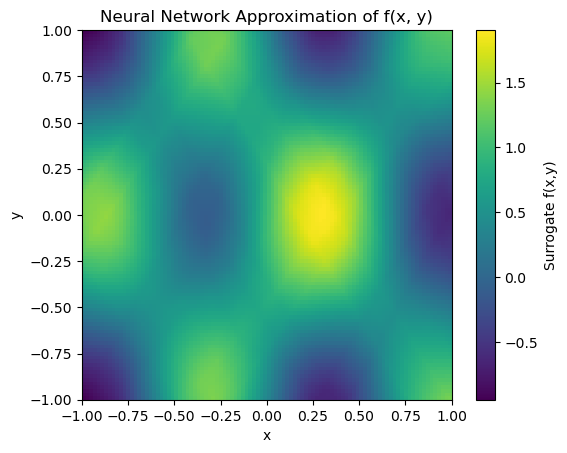

In [17]:
# Visualize learned function
grid_x, grid_y = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
grid = np.column_stack((grid_x.ravel(), grid_y.ravel()))
grid_tensor = torch.tensor(grid, dtype=torch.float32)
with torch.no_grad():
    grid_pred = model(grid_tensor).numpy().reshape(100, 100)

plt.imshow(grid_pred, extent=(-1,1,-1,1), origin='lower', cmap='viridis')
plt.colorbar(label='Surrogate f(x,y)')
plt.title("Neural Network Approximation of f(x, y)")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

The above heatgraph shows the neural network's predicted values of the function f(x,y) over the domain mentioned above. Each point (x,y) in that square has a color representing the predicted value from the trained neural network. 
* Blue or dark mean low values.
* Yellow, green mean high values.

A smooth gradient across the image indicates a stable and consistent approximation.

#### Trying more sample sizes and comparing the accuracies of them.

In [22]:
# 1. High-accuracy reference value using many samples
true_reference = monte_carlo_integrate(f, N=1000000)  # Ground truth

In [34]:
# 2. Define sample sizes to test
sample_sizes = [100, 500, 1000, 5000, 10000, 50000, 100000]

true_mc_results = []
surrogate_mc_results = []

In [36]:
for N in sample_sizes:
    true_val = monte_carlo_integrate(f, N)
    surrogate_val = surrogate_monte_carlo(model, N)
    
    true_mc_results.append(true_val)
    surrogate_mc_results.append(surrogate_val)

In [40]:
# 4. Convert to numpy arrays
true_mc_results = np.array(true_mc_results)
surrogate_mc_results = np.array(surrogate_mc_results)
sample_sizes = np.array(sample_sizes)

In [42]:
print("Sample Sizes:", sample_sizes)
print("True MC Results:", true_mc_results)
print("Surrogate MC Results:", surrogate_mc_results)

Sample Sizes: [   100    500   1000   5000  10000  50000 100000]
True MC Results: [2.35061885 2.22002421 2.25872898 2.21010338 2.23418066 2.24302761
 2.23013822]
Surrogate MC Results: [2.09619   2.267171  2.2050524 2.2151942 2.2440898 2.2245257 2.2447507]


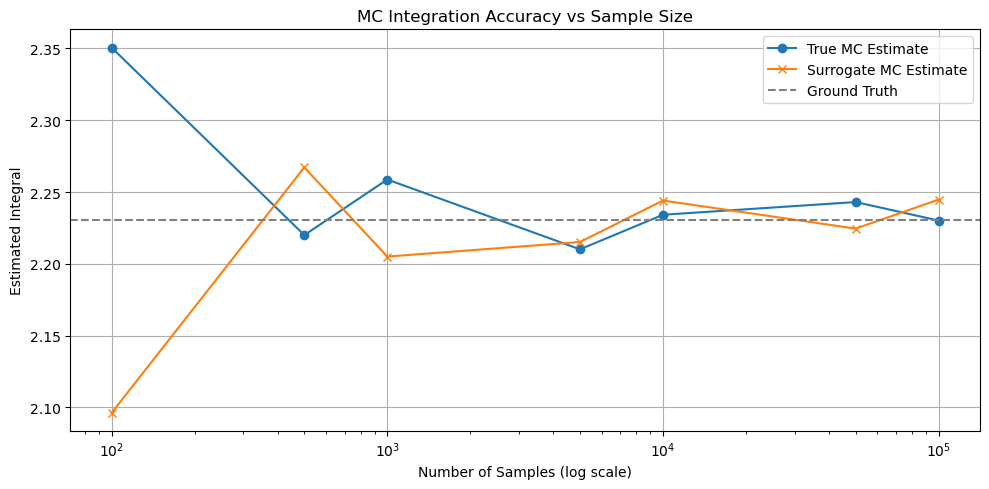

In [44]:
# 5. Plot the estimates
plt.figure(figsize=(10, 5))
plt.plot(sample_sizes, true_mc_results, label="True MC Estimate", marker='o')
plt.plot(sample_sizes, surrogate_mc_results, label="Surrogate MC Estimate", marker='x')
plt.axhline(true_reference, color='gray', linestyle='--', label='Ground Truth')
plt.xscale('log')
plt.xlabel('Number of Samples (log scale)')
plt.ylabel('Estimated Integral')
plt.title('MC Integration Accuracy vs Sample Size')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

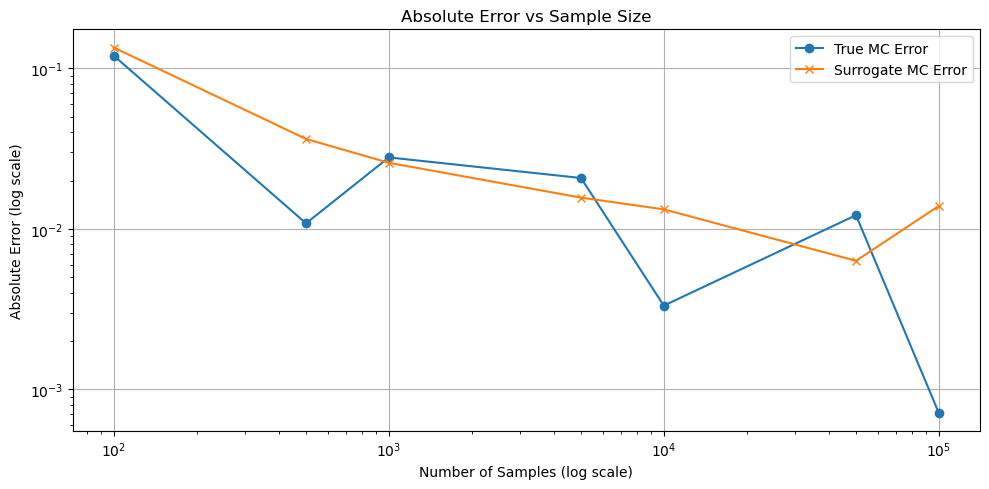

In [46]:
# 6. Plot the absolute error
plt.figure(figsize=(10, 5))
true_error = np.abs(true_mc_results - true_reference)
surrogate_error = np.abs(surrogate_mc_results - true_reference)

plt.plot(sample_sizes, true_error, label="True MC Error", marker='o')
plt.plot(sample_sizes, surrogate_error, label="Surrogate MC Error", marker='x')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Samples (log scale)')
plt.ylabel('Absolute Error (log scale)')
plt.title('Absolute Error vs Sample Size')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()